# Model Training with iQual

This notebook demonstrates advanced training techniques including cross-validation and hyperparameter optimization using the same politeness dataset from Getting Started.

## 1. Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from iqual import iqualnlp, evaluation, crossval
import matplotlib.pyplot as plt
import seaborn as sns
from convokit import Corpus, download

# Download the Stanford Politeness Corpus (same as in Getting Started)
print("Downloading the Stack Exchange Politeness Corpus...")
corpus = Corpus(filename=download("stack-exchange-politeness-corpus"))
print(f"Download complete. Corpus contains {len(corpus.get_utterance_ids())} utterances.")

# Process the corpus into a DataFrame (using the same code from Getting Started)
rows = []
for utt in corpus.iter_utterances():
    request_text = utt.text
    meta = utt.meta
    if 'Binary' in meta:
        binary_label = meta['Binary']
        is_polite = 1 if binary_label == 1 else 0
        
        if len(request_text.split('.')) > 1:
            parts = request_text.split('.', 1)
            context_text = parts[0] + '.'
            request_text = parts[1].strip()
        else:
            context_text = "Stack Exchange discussion:"
        
        rows.append({
            'question': context_text,
            'answer': request_text,
            'is_polite': is_polite
        })        

# Convert to DataFrame
data = pd.DataFrame(rows)
data = data[data['question'].str.len() > 0]
data = data[data['answer'].str.len() > 0]


print(f"Created DataFrame with {len(data)} records")
print(f"Polite requests: {sum(data['is_polite'] == 1)}")
print(f"Impolite requests: {sum(data['is_polite'] == 0)}")

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
X_train = train_data[['question', 'answer']]
y_train = train_data['is_polite']
X_test = test_data[['question', 'answer']]
y_test = test_data['is_polite']


Dataset already exists at /Users/adityachhabra/.convokit/saved-corpora/stack-exchange-politeness-corpus
Download complete. Corpus contains 6603 utterances.
Created DataFrame with 6596 records
Polite requests: 1649
Impolite requests: 4947


## 2. Configuring a Parameter Grid for Cross-Validation

In [3]:
question_col = 'question'
answer_col   = 'answer'

# Define vectorizer options
# Option 1: Use scikit-learn vectorizers [https://scikit-learn.org/stable/api/sklearn.feature_extraction.html]

SKLEARN_QA_PARAMS = {
    "Input": {
        "question": {
            "vectorizer": {
                "model": ['TfidfVectorizer', 'CountVectorizer'],
                "env": ['scikit-learn'],
                'max_features': np.arange(1000, 6000, 1000),
                'ngram_range': [(1, 1), (1, 2)]
            }
        },
        "answer": {
            "vectorizer": {
                "model": ['TfidfVectorizer', 'CountVectorizer'],
                "env": ['scikit-learn'],
                'max_features': np.arange(1500, 6500, 1000),
                'ngram_range': [(1, 1), (1, 2)]
            }
        }
    }
}

# Option 2: Use only Answer text with scikit-learn vectorizers [https://www.sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html]
SKLEARN_A_PARAMS = {
    "Input": {
        "question": ["drop"], 
        "answer": {
            "vectorizer": {
                "model": ['TfidfVectorizer', 'CountVectorizer'],
                "env": ['scikit-learn'],
                'max_features': np.arange(1500, 6500, 1000)
            }
        }
    }
}

# Option 3: Use sentence transformers for both question and answer
SBERT_PARAMS = {
    "Input": {
        "question": {
            "vectorizer": {
                "model": ['distiluse-base-multilingual-cased-v2'],
                "env": ['sentence-transformers']
            }
        },
        "answer": {
            "vectorizer": {
                "model": ['distiluse-base-multilingual-cased-v2'],
                "env": ['sentence-transformers']
            }
        }
    }
}

# Define classifier options [https://scikit-learn.org/stable/api/sklearn.linear_model.html]
LOGISTIC_PARAMS = {
    "Classifier": {
        "model": ["LogisticRegression"],
        "C": [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['saga']
    }
}
# [https://scikit-learn.org/stable/api/sklearn.ensemble.html]
RANDOM_FOREST_PARAMS = {
    "Classifier": {
        "model": ["RandomForestClassifier"],
        "n_estimators": [100, 200],
        'max_depth': [5, 10, 20]
    }
}

SVC_PARAMS = {
    "Classifier": {
        "model": ["SVC"],
        "C": [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'probability': [True]
    }
}

# Combine vectorization and classifier parameters
VECTORIZATION_PARAMS = [SKLEARN_QA_PARAMS, SKLEARN_A_PARAMS, SBERT_PARAMS]
CLASSIFIER_PARAMS = [LOGISTIC_PARAMS, RANDOM_FOREST_PARAMS, SVC_PARAMS]

# Create all combinations of parameters
ALL_PARAM_COMBINATIONS = [{**vect_params, **clf_params} for vect_params in VECTORIZATION_PARAMS for clf_params in CLASSIFIER_PARAMS]

# Convert the nested parameter dictionary to the format expected by scikit-learn
CV_SEARCH_PARAMS = [crossval.convert_nested_params(p) for p in ALL_PARAM_COMBINATIONS]
print(f"Number of hyperparameter configurations: {crossval.count_hyperparameters(CV_SEARCH_PARAMS)}")


Number of hyperparameter configurations: 456


# 3. Instantiate an iQual model

In [23]:
# Create a model
hp_model = iqualnlp.Model()
hp_model.add_text_features(question_col, answer_col)
hp_model.add_classifier()
hp_model.add_threshold(scoring_metric='f1')
hp_model.compile()

Pipeline(steps=[('Input',
                 FeatureUnion(transformer_list=[('question',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function column_selector at 0x11d109c60>,
                                                                                      kw_args={'column_name': 'question'})),
                                                                 ('vectorizer',
                                                                  Vectorizer(analyzer='word',
                                                                             binary=False,
                                                                             decode_error='strict',
                                                                             dtype=<class 'numpy.float64'>,
                                                                             encoding='utf-8',
                                                                             env='scikit-learn',
                                                                             input='conte...
                                                                             tokenizer=None,
                                                                             use_idf=True,
                                                                             vocabulary=None))]))])),
                ('Classifier',
                 Classifier(C=1.0, class_weight=None, dual=False,
                            fit_intercept=True, intercept_scaling=1,
                            l1_ratio=None, max_iter=100,
                            model='LogisticRegression',
                            multi_class='deprecated', n_jobs=None, penalty='l2',
                            random_state=None, solver='lbfgs', tol=0.0001,
                            verbose=0, warm_start=False)),
                ('Threshold', BinaryThresholder())])

In [24]:
## Define scoring metrics
scoring_dict = evaluation.get_scoring_dict(['accuracy', 'precision', 'recall', 'f1'])
scoring_dict

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict', average=binary),
 'recall': make_scorer(recall_score, response_method='predict', average=binary),
 'f1': make_scorer(f1_score, response_method='predict', average=binary)}

## 4. Run cross-validation with hyperparameter search

In [58]:
## Create a standard KFold splitter
from sklearn.model_selection import KFold
n_splits = 3
kfold    = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [137]:
print("Running cross-validation with hyperparameter search...")

cv_dict = hp_model.cross_validate_fit(
    X_train,
    y_train,
    search_parameters=CV_SEARCH_PARAMS,
    cv_method='RandomizedSearchCV',    # Options: 'GridSearchCV', 'RandomizedSearchCV'
    n_iter=10, 
    # NOTE: Using `RandomizedSearchCV` and 10 iterations for demonstration purposes.
    
    scoring=scoring_dict,        # Dictionary of scoring metrics
    refit='f1',                  # Metric to use for selecting the best model
    n_jobs=8,                   # Use all available processors
    cv_splits=kfold,                 # Number of cross-validation folds
)

Running cross-validation with hyperparameter search...


/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adityachhabra

In [138]:
# Display cross-validation results of best score
print(f"Average test score across folds: {cv_dict['avg_test_score']:.3f}")

Average test score across folds: 0.414


## 5. Analyzing the Best Model Parameters

In [139]:
# Get the best parameters from cross-validation
best_params_df = pd.DataFrame([hp_model.cv.get_best_params()])
# Extract and display the most important parameters
selected_params = {}
for param, value in best_params.items():
    if 'model' in param or 'max_features' in param or 'C' in param or 'n_estimators' in param:
        selected_params[param] = value

selected_params['decision_threshold'] = hp_model.get_params()['steps'][-1][-1].threshold

print("Best Model Configuration:")
for param, value in selected_params.items():
    print(f"  {param}: {value}")

Best Model Configuration:
  Input__question__vectorizer__model: TfidfVectorizer
  Input__answer__vectorizer__model: TfidfVectorizer
  Classifier__solver: saga
  Classifier__penalty: l1
  Classifier__model: LogisticRegression
  Classifier__C: 1
  decision_threshold: 0.19955704558360515


## 6. Fold-by-Fold Cross-Validation Predictions with Best Parameters

In [140]:
# Initialize arrays to store CV predictions
cv_train_pred = np.zeros(len(X_train))
cv_train_proba = np.zeros(len(X_train))


# Get CV splits
cv_splits = list(kfold.split(X_train))

# For each fold
for fold_idx, (train_idx, val_idx) in enumerate(cv_splits):
    print(f"Processing fold {fold_idx + 1}/{n_splits}")
    
    # Get fold training and validation data
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    
    # Create and train model with best parameters
    fold_model = iqualnlp.Model()
    fold_model.add_text_features(question_col, answer_col)
    fold_model.add_classifier()
    fold_model.add_threshold(scoring_metric='f1')  # Same as refit parameter
    fold_model.compile()
    
    # Set best parameters and fit
    fold_model.set_params(**best_params)
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Predict on validation fold
    cv_train_pred[val_idx] = fold_model.predict(X_fold_val)
    cv_train_proba[val_idx] = fold_model.predict_proba(X_fold_val)

Processing fold 1/3
Processing fold 2/3


/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing fold 3/3


/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 7. Evaluate Fold-by-Fold Predictions

Fold-by-Fold Cross-Validation Performance Metrics:
  Accuracy: 0.5229
  Precision: 0.2918
  Recall: 0.6254
  F1 Score: 0.3979

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.49      0.60      3453
           1       0.29      0.63      0.40      1164

    accuracy                           0.52      4617
   macro avg       0.54      0.56      0.50      4617
weighted avg       0.67      0.52      0.55      4617



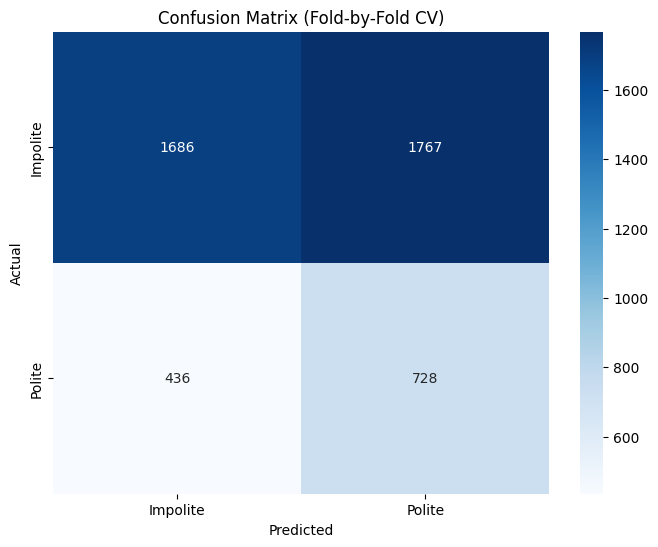

In [141]:
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# Calculate metrics on fold-by-fold predictions
fold_metrics = {
    'Accuracy': accuracy_score(y_train, cv_train_pred),
    'Precision': precision_score(y_train, cv_train_pred),
    'Recall': recall_score(y_train, cv_train_pred),
    'F1 Score': f1_score(y_train, cv_train_pred)
}

print("Fold-by-Fold Cross-Validation Performance Metrics:")
for metric, value in fold_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_train, cv_train_pred))

# Create confusion matrix
cm = confusion_matrix(y_train, cv_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Impolite', 'Polite'],
            yticklabels=['Impolite', 'Polite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Fold-by-Fold CV)')
plt.show()

## 8. Train Final Model and Evaluate on Test Set

/Users/adityachhabra/squizzyenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test Set Performance Metrics:
  Accuracy: 0.5296
  Precision: 0.2987
  Recall: 0.6825
  F1 Score: 0.4156

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.48      0.61      1494
           1       0.30      0.68      0.42       485

    accuracy                           0.53      1979
   macro avg       0.56      0.58      0.51      1979
weighted avg       0.69      0.53      0.56      1979



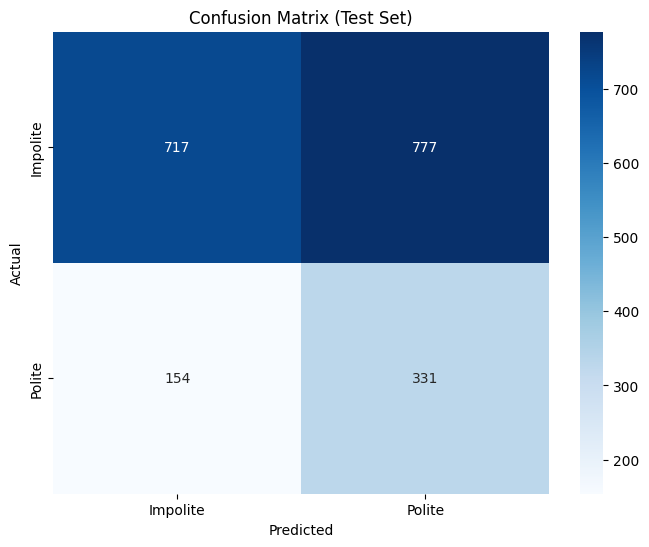

In [142]:
# Train final model on all training data
final_model = iqualnlp.Model()
final_model.add_text_features(question_col, answer_col)
final_model.add_classifier()
final_model.add_threshold(scoring_metric='f1')
final_model.compile()
final_model.set_params(**best_params)
final_model.fit(X_train, y_train)

# Predict on test set
test_pred = final_model.predict(X_test)
test_proba = final_model.predict_proba(X_test)

# Calculate metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, test_pred),
    'Precision': precision_score(y_test, test_pred),
    'Recall': recall_score(y_test, test_pred),
    'F1 Score': f1_score(y_test, test_pred)
}

print("Test Set Performance Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, test_pred))

# Create confusion matrix for test predictions
cm_test = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Impolite', 'Polite'],
            yticklabels=['Impolite', 'Polite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

## Compare CV Performance vs Test Performance

      Metric  Cross-Validation  Test Set
0   Accuracy          0.522850  0.529560
1  Precision          0.291784  0.298736
2     Recall          0.625430  0.682474
3   F1 Score          0.397923  0.415568


<Figure size 1000x600 with 0 Axes>

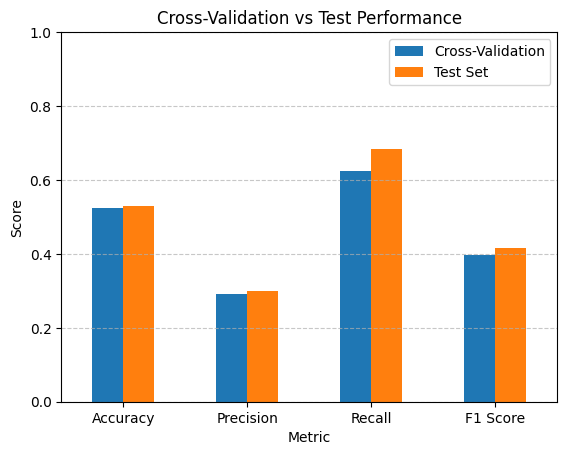

In [143]:
# Create a DataFrame to compare CV and test metrics
comparison_df = pd.DataFrame({
    'Metric': list(fold_metrics.keys()),
    'Cross-Validation': list(fold_metrics.values()),
    'Test Set': list(test_metrics.values())
})

print(comparison_df)

# Plot comparison
plt.figure(figsize=(10, 6))
comparison_df.set_index('Metric').plot(kind='bar', rot=0)
plt.ylabel('Score')
plt.title('Cross-Validation vs Test Performance')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Examine Predictions

In [144]:
# Create a DataFrame with test examples and their predictions
results_df = pd.DataFrame({
    'Question': X_test['question'],
    'Answer': X_test['answer'],
    'True Label': y_test,
    'Predicted Label': test_pred,
    'Probability': test_proba
})

# Calculate prediction error (0 = correct, 1 = incorrect)
results_df['Error'] = (results_df['True Label'] != results_df['Predicted Label']).astype(int)

### Examples of Correct Predictions (Polite):

In [145]:
results_df[(results_df['True Label'] == 1) & (results_df['Error'] == 0)].head(3)[['Question', 'Answer', 'Probability']]

,Question,Answer,Probability
96,"This looks right, and works for me.",What do you see?,0.334304
6545,Thanks.,"BTW, should I mince the parsley before frying it?",0.641810
4415,@damonokz Sorry maybe I misunderstood somethin...,So the guys here who are trying to answer your...,0.246023


### Examples of Correct Predictions (Impolite):

In [146]:
results_df[(results_df['True Label'] == 0) & (results_df['Error'] == 0)].head(3)[['Question', 'Answer', 'Probability']]

,Question,Answer,Probability
3169,Stack Exchange discussion:,So you're trying to use remote debugging? Have...,0.225389
395,Stack Exchange discussion:,Why would you need to parse the HTML that you ...,0.174796
2205,Stack Exchange discussion:,"""Not a real question"" ? What is the ""not real""...",0.189892


### Examples of Incorrect Predictions (False Negatives)

In [147]:
results_df[(results_df['True Label'] == 1) & (results_df['Error'] == 1)].head(3)[['Question', 'Answer', 'Probability']]

,Question,Answer,Probability
474,You may want to define efficient/clean.,"Do you mean simplest in terms of expression, o...",0.199029
3524,Stack Exchange discussion:,How exactly have you set its height? Have you...,0.227073
2417,Stack Exchange discussion:,What environment are you developing under? OS ...,0.204043


### Examples of Incorrect Predictions (False Positives):

In [148]:
results_df[(results_df['True Label'] == 0) & (results_df['Error'] == 1)].head(3)[['Question', 'Answer', 'Probability']]

,Question,Answer,Probability
5122,"you have not provider the 11,21,31 code for th...",Can you provide dxf file so I can get a better...,0.695675
2529,"During transcoding, were the audio files upsam...",g. converting 8-bit 11kHz to 16-bit 44kHz?,0.244150
683,Stack Exchange discussion:,Are you trying to create an advert that plays ...,0.286604


## Probability distributions by true label

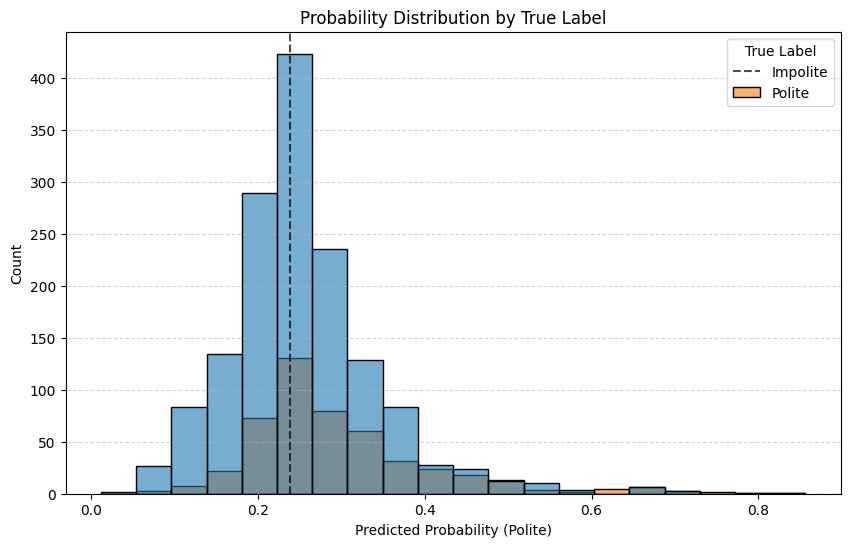

In [149]:
decision_threshold_final = final_model.get_params()['steps'][-1][-1].threshold

plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Probability', hue='True Label', bins=20, alpha=0.6)
plt.axvline(x=decision_threshold_final, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
plt.title('Probability Distribution by True Label')
plt.xlabel('Predicted Probability (Polite)')
plt.ylabel('Count')
plt.legend(title='True Label', labels=['Impolite', 'Polite'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Summary

In [150]:
print(f"Best model parameters were selected from {crossval.count_hyperparameters(CV_SEARCH_PARAMS)} hyperparameter combinations")
print(f"Best model F1 score in cross-validation: {cv_dict['avg_test_score']:.4f}")
print(f"Final model F1 score on test set: {test_metrics['F1 Score']:.4f}")

# Extract the key components of the best model
best_vectorizers = []
for param, value in best_params.items():
    if 'vectorizer__model' in param and isinstance(value, str):
        component = param.split('__')[1]  # question or answer
        best_vectorizers.append(f"{component}: {value}")

best_classifier = best_params.get('Classifier__model', 'Unknown')

print("\n" + '-'*50)
print("\nBest Model Configuration:")
print("\n" + '-'*50 + '\n')
print(f"Vectorizer(s): {', '.join(best_vectorizers)}")
print(f"Classifier: {best_classifier}")
print(f"Decision Boundary: {decision_threshold_final:.2f}")

Best model parameters were selected from 456 hyperparameter combinations
Best model F1 score in cross-validation: 0.4136
Final model F1 score on test set: 0.4156

--------------------------------------------------

Best Model Configuration:

--------------------------------------------------

Vectorizer(s): question: TfidfVectorizer, answer: TfidfVectorizer
Classifier: LogisticRegression
Decision Boundary: 0.24
